# Poisson Regression

All three Generalized Linear Models (GLM) currently available in scikit-learn have been integrated for FHE in Concrete-ML: PoissonRegressor, GammaRegressor and TweedieRegressor. Detailed information about those models can be found in their associated [documentation](https://scikit-learn.org/stable/modules/classes.html#:~:text=Generalized%20linear%20models%20(GLM)%20for%20regression).

This tutorial shows how to train PoissonRegressor and then run it in FHE using Concrete-ML. We make use of strong quantization to ensure the accumulator of the linear part does not overflow when computing in FHE (8-bit accumulator). We show that this process does not degrade performance with respect to the quantized model working on values in the clear.

### Import libraries

We import scikit-learn libraries, Concrete-Numpy quantization tools as well as the Poisson regression model:

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.linear_model import PoissonRegressor as SklearnPoissonRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import PoissonRegressor as ConcretePoissonRegressor

And, finally, we import some helpers for visualization:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Insurance claims dataset

In this tutorial, we show how to build a regression model that predicts the frequency of incidents in an insurance setting.

We download a dataset from OpenML that contains 670,000 examples giving the frequency of car accidents for drivers of various ages, past accident history, car type, car color, geographical region, etc. We take only the first 50,000 examples to speed up training.


In [3]:
df, _ = fetch_openml(
    data_id=41214, as_frame=True, cache=True, data_home="~/.cache/sklean", return_X_y=True
)
df = df.head(50000)

The target variable is the number of claims per year, which is computed by the following formula :

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

Let's visualize our dataset, showing that the target variable, "Frequency" has a Poisson distribution.

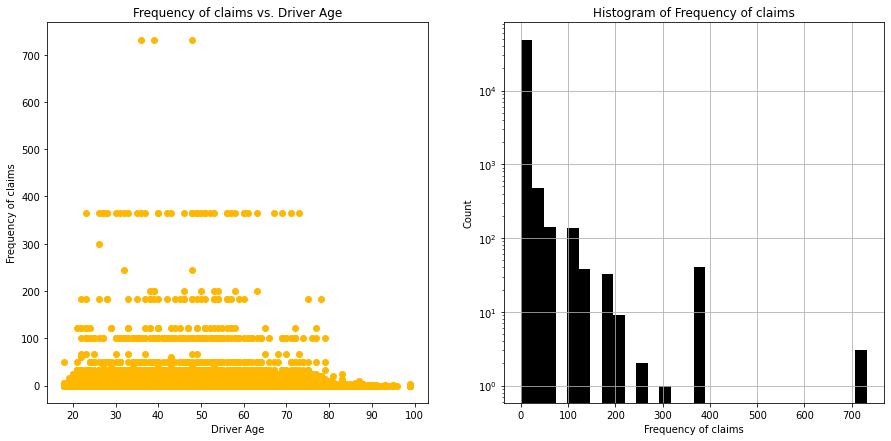

In [5]:
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.patch.set_facecolor("white")
ax[0].set_title("Frequency of claims vs. Driver Age")
ax[0].set_xlabel("Driver Age")
ax[0].set_ylabel("Frequency of claims")
ax[0].scatter(df["DrivAge"], df["Frequency"], marker="o", color="#ffb700")
ax[1].set_title("Histogram of Frequency of claims")
ax[1].set_xlabel("Frequency of claims")
ax[1].set_ylabel("Count")
df["Frequency"].hist(bins=30, log=True, ax=ax[1], color="black")
display(fig)

We split the data into a training and a test set, but we also keep a part of the data to be used for calibration. This calibration set is not used for training, nor for testing the model. Thus, we ensure better generalization of the quantized model.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_calib, df_test = train_test_split(df_test, test_size=100, random_state=0)

## Simple single variable insurance incident frequency predictor

Our initial example only uses a single predictor feature, so we can easily visualize results. 

Let's extract our train and test data:

In [7]:
train_data = df_train["DrivAge"].values.reshape(-1, 1)
test_data = np.sort(df_test["DrivAge"].values).reshape(-1, 1)

We first train the scikit-learn PoissonRegressor model:

In [8]:
sklearn_regressor = SklearnPoissonRegressor(max_iter=300)
sklearn_regressor.fit(train_data, df_train["Frequency"])

PoissonRegressor(max_iter=300)

We can now test this predictor on the test data:

In [9]:
sklearn_predictions = sklearn_regressor.predict(test_data)

Now, let's visualize our predictions to see how our model performs.

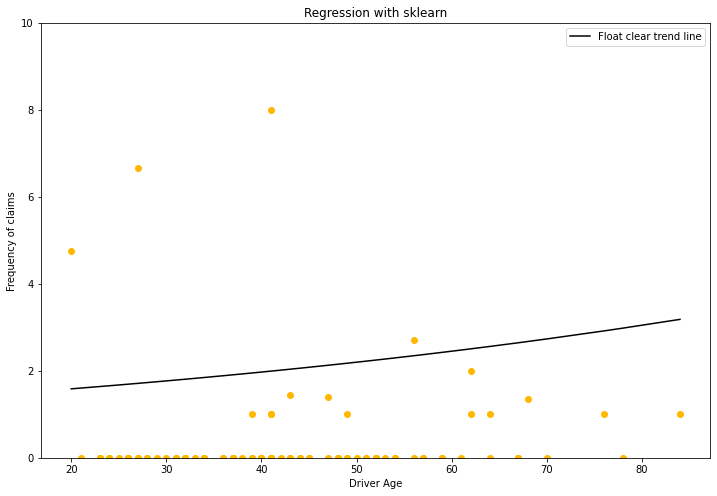

In [10]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(test_data, sklearn_predictions, color="black", label="Float clear trend line")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="#ffb700")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Regression with sklearn")
ax.set_ylabel("Frequency of claims")
ax.legend(loc="upper right")
display(fig)

### Analysis

The trend line obtained from the model suggests an increase of incidents with driver age, but the data shows that incidents peak around 30 to 40 years of age, with a decrease afterwards. This simple model does not seem to be a good one. We will still convert it to FHE to visually compare some details of the conversion and then train a more powerful model afterwards.

### Let's visualize the performance of a **quantized Poisson regressor**

First, we train the concrete PoissonRegressor model that will quantize the inputs using 5 bits:

In [11]:
concrete_regressor = ConcretePoissonRegressor(n_bits=5, max_iter=300)
concrete_regressor.fit(train_data, df_train["Frequency"])

We can now test this predictor on the test data the same way we did with scikit-learn:

In [12]:
concrete_predictions = concrete_regressor.predict(test_data)

Finally, let's visualize the quantized model's results by measuring the goodness of fit on the test data using the Poisson deviance.

In [13]:
y_true = df_test["Frequency"]
sample_weight = df_test["Exposure"]

sklearn_score = mean_poisson_deviance(y_true, sklearn_predictions, sample_weight=sample_weight)
concrete_score = mean_poisson_deviance(y_true, concrete_predictions, sample_weight=sample_weight)

print(f"mean Poisson deviance (float): {sklearn_score}")
print(f"mean Poisson deviance (quant): {concrete_score}")

mean Poisson deviance (float): 3.711521947502187
mean Poisson deviance (quant): 3.7089289132757783


We then plot the two trend lines (float value model and quantized model) to check for differences. 

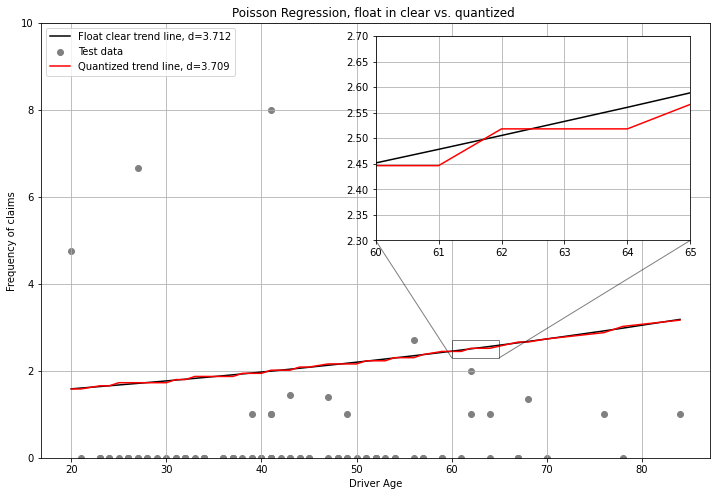

In [14]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"Float clear trend line, d={sklearn_score:.3f}",
)
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear vs. quantized ")
ax.set_ylabel("Frequency of claims")
ax.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Quantized trend line, d={concrete_score:.3f}",
)
ax.legend(loc="upper left")
ax.grid()

# Insert axes
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"Float clear trend line, d={sklearn_score:.3f}",
)
axins.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Quantized trend line, d={concrete_score:.3f}",
)

# Define the sub region
x1, x2, y1, y2 = 60, 65, 2.3, 2.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

### Analysis

In the graph above, the trend line of the quantized model is more jaggy. The tradeoff between better fit and compatibility with FHE compilation needs to be made by the practitioner.

### Now it's time to make the inference homomorphic. 

Compiling a model to FHE is done with a single line of code:

In [15]:
concrete_regressor.compile(test_data)

Now we can test the model on the test set in FHE by simply set `execute_in_fhe` to `True`:

In [16]:
concrete_predictions_fhe = concrete_regressor.predict(test_data, execute_in_fhe=True)

Finally, we check if there are any differences to the quantized model on non-encrypted clear data by plotting the trend lines. Sometimes, FHE noise can create minor artifacts.

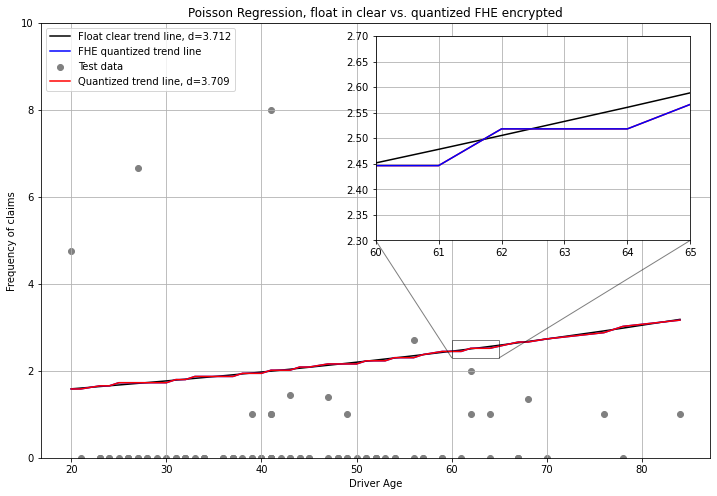

In [17]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"Float clear trend line, d={sklearn_score:.3f}",
)
ax.plot(test_data, concrete_predictions_fhe, color="blue", label="FHE quantized trend line")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear vs. quantized FHE encrypted")
ax.set_ylabel("Frequency of claims")
ax.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Quantized trend line, d={concrete_score:.3f}",
)
ax.legend(loc="upper left")
ax.grid()

axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"Float clear trend line, d={sklearn_score:.3f}",
)
axins.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Quantized FHE trend line, d={concrete_score:.3f}",
)
axins.plot(test_data, concrete_predictions_fhe, color="blue", label="FHE quantized trend line")
x1, x2, y1, y2 = 60, 65, 2.3, 2.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

## A multi-variate model

The simple single-variable model does not achieve good results (age is not a good predictor for the number of claims). So, let's train a model with all of our predictor variables. We proceed by transforming the raw features into ones that can be input into a regression model. Thus, the categorical features are transformed into one-hot encoding, but we can also reduce the resolution of vehicles and persons by binning. Transforming the data this way, we end up with a total of 57 continuous features (instead of the initial 11).

Here is where we encounter one of the limitations of our framework. We perform a dot product in the prediction, in the QuantizedLinear class, but in our framework the maximum integer size is, for now, limited to 8 bits. As every multiplication doubles the number of bits of precision of the inputs performing 57 multiplication-additions of integers to compute w.x would quickly overflow 8 bits. 

As a workaround to the limited accumulator resolution, we perform PCA to reduce dimensionality from 57 to 12 dimensions and train our multi-variate model in this reduced dimensionality space. 

In [18]:
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

warnings.filterwarnings("ignore")

Let's train three models:
- a scikit-learn reference model, trained on all of the original features
- a scikit-learn model, trained on features extracted by PCA transformation
- a Concrete-ML quantized model, trained on features extracted by PCA transformation 

In [19]:
log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(sparse=False),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

sklearn_regressor = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", SklearnPoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)

sklearn_regressor_pca = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("pca", PCA(n_components=12, whiten=True)),
        ("regressor", SklearnPoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)

n_bits = {"inputs": 3, "weights": 2, "outputs": 8}
concrete_regressor_pca = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("pca", PCA(n_components=12, whiten=True)),
        ("regressor", ConcretePoissonRegressor(n_bits=n_bits, alpha=1e-12, max_iter=300)),
    ]
)

sklearn_regressor.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

sklearn_regressor_pca.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

concrete_regressor_pca.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Density']),
                                 

Now, let's evaluate the models.

In [20]:
def score_estimator(estimator, df_test, execute_in_fhe=False):
    """Score an estimator on the test set."""

    if execute_in_fhe:
        y_pred = estimator.predict(df_test, execute_in_fhe=execute_in_fhe)
    else:
        y_pred = estimator.predict(df_test)

    y_pred = np.squeeze(y_pred)
    y_true = df_test["Frequency"]
    sample_weight = df_test["Exposure"]

    # Ignore non-positive predictions, as they are invalid for the Poisson deviance. We want to
    # issue a warning if for some reason (e.g. FHE noise, bad quantization, user error),
    # the regressor predictions are negative

    # Find all strictly positive values
    mask = y_pred > 0

    # If any non-positive values are found, issue a warning
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f"for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    return mean_poisson_deviance(y_true[mask], y_pred[mask], sample_weight=sample_weight[mask])

In [21]:
print(f"Sklearn PoissonRegressor score: {score_estimator(sklearn_regressor, df_test):.4f}")
print(f"Sklearn PoissonRegressor+PCA score: {score_estimator(sklearn_regressor_pca, df_test):.4f}")
print(
    f"Concrete PoissonRegressor+PCA score: {score_estimator(concrete_regressor_pca, df_test):.4f}"
)

Sklearn PoissonRegressor score: 1.3761
Sklearn PoissonRegressor+PCA score: 1.4393
Concrete PoissonRegressor+PCA score: 1.5217


We can observe that using the Concrete-ML quantized model over dimensional reduced data slightly increases the Mean Poisson Deviance score over the reference model's one.

### Test the multi-variate GLM with multiple quantization bit widths for inputs

In [22]:
n_bits_inputs_values = [28, 16, 6, 5, 4, 3, 2]
deviance_score = []
for n_bits_inputs in n_bits_inputs_values:
    n_bits = {"inputs": n_bits_inputs, "weights": 2, "outputs": 8}
    concrete_regressor_pca_n_bit = Pipeline(
        [
            ("preprocessor", linear_model_preprocessor),
            ("pca", PCA(n_components=12, whiten=True)),
            ("regressor", ConcretePoissonRegressor(n_bits=n_bits, alpha=1e-12, max_iter=300)),
        ]
    )
    concrete_regressor_pca_n_bit.fit(
        df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
    )
    deviance_score.append(score_estimator(concrete_regressor_pca_n_bit, df_test))

We plot the Poisson deviance with respect to the quantized bit width, to show how performance degrades with quantization:

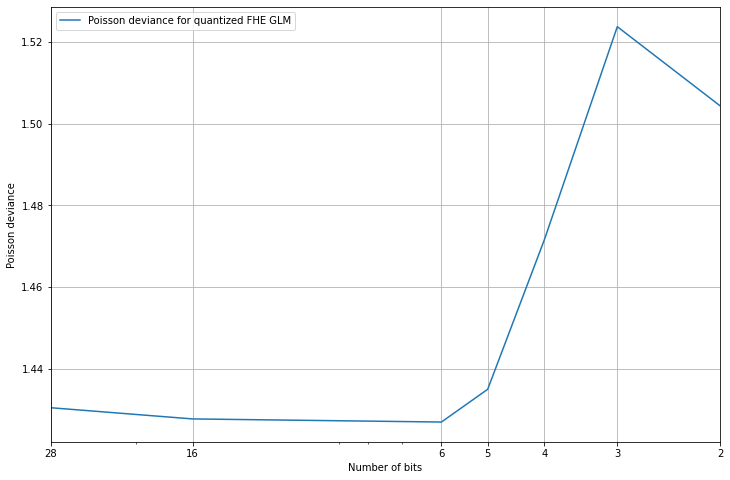

In [23]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(n_bits_inputs_values, deviance_score, label="Poisson deviance for quantized FHE GLM")
ax.set_xlim(2, 28)
ax.invert_xaxis()
ax.set_xlabel("Number of bits")
ax.set_ylabel("Poisson deviance")
ax.set_xscale("log")
ax.set_xticks(n_bits_inputs_values)
ax.set_xticklabels([str(k) for k in n_bits_inputs_values])
ax.grid()
ax.legend(loc="upper left")
display(fig)

### Analysis

While the prediction quality is mostly stable until 5 bits, we can observe a slight decrease in prediction performance in lower bit widths.

### Compile the multi-variate GLM to FHE. 

Because of the limited bitwidth of accumulators, the number of bits used in quantization as well as the number of PCA components to consider can't exceed certain values. For example, with 12 features, inputs and weights can only be quantized with at most 3 and 2 bits respectively (or the other way around, depending on the needs). 

However, this is a theoretical limit that ensures the model compiles with a 100% certainty in the **worst case** (if inputs and weights reach their maximum values). In practice, it is still possible to compile a model with higher parameter values (more components or bits of quantization) and thus acquiring more precision. Unfortunately, for now, the only way to find out this limit is to train multiple times as long as the accuracy increases and the model compiles.

More information about the relation between bitwidths and the number of PCA components for FHE computations can be found [here](https://docs.zama.ai/concrete-ml/stable/user/howto/reduce_needed_precision.html#:~:text=for%20model%20weights.-,Limitations%20for%20FHE%20friendly%20neural%20networks).

In [24]:
n_bits = {"inputs": 3, "weights": 2, "outputs": 8}

poisson_regressor_fhe = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("pca", PCA(n_components=12, whiten=True)),
        ("regressor", ConcretePoissonRegressor(n_bits=n_bits, alpha=1e-12, max_iter=300)),
    ]
)
poisson_regressor_fhe.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['BonusMalus']),
                                                 ('binned_numeric',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['VehAge', 'DrivAge']),
                                                 ('log_scaled_numeric',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Density']),
                                 

Again, with a single line of code we compile to FHE:

In [25]:
# Compile needs some preprocessed data in order to run.
df_test_pca = poisson_regressor_fhe["pca"].transform(
    poisson_regressor_fhe["preprocessor"].transform(df_test)
)

# pylint: disable=no-member
poisson_regressor_fhe["regressor"].compile(df_test_pca)

# pylint: enable=no-member

Finally, we evaluate the model on encrypted data:

In [26]:
quantized_pca_fhe_score = score_estimator(poisson_regressor_fhe, df_test, execute_in_fhe=True)

print(f"PoissonRegressor score: {score_estimator(sklearn_regressor, df_test):.4f}")
print(f"PoissonRegressor+PCA score: {score_estimator(sklearn_regressor_pca, df_test):.4f}")
print(f"FHE Quantized score: {quantized_pca_fhe_score:.4f}")

PoissonRegressor score: 1.3761
PoissonRegressor+PCA score: 1.4393
FHE Quantized score: 1.4996


## Conclusion

In this tutorial, we have discussed how we can use Concrete-ML in order to manipulate a Poisson regression model in FHE. 

First of all, we have shown that with the proper choice of pipeline and parameters, we can apply quantization to the model with little loss of precision. This decrease in the quality of prediction is due to the quantization of model weights and input data, as well as some minor noise from FHE computations. In fact, this noise is visible on the single variable FHE trend line as minor deviations of the blue curve with respect to the red one. 

Finally, we have shown how the model can be used in FHE with a single line of code and how quantization is aided by the tools from Concrete-Numpy. 
